# Разработка сверточной нейронной сети

## 1. Подготовка данных и окружения

In [10]:
!pip install torchvision

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.6 MB 2.1 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.6 MB 2.0 MB/s eta 0:00:01
   --------------------------------- ------ 1.3/1.6 MB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 2.1 MB/s eta 0:00:00


C:\Users\ASUS\Desktop\projects\project4\src\chest_xray\train\NORMAL


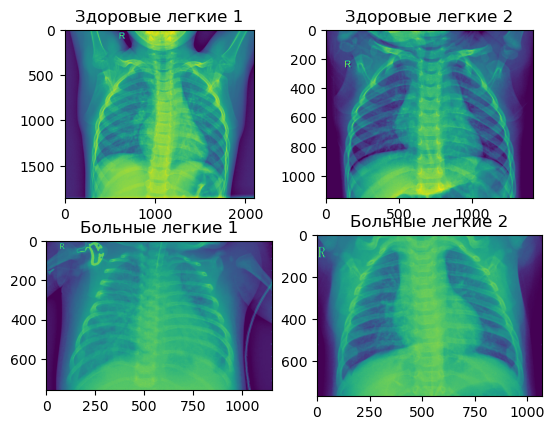

In [5]:
# Загрузка двух изображений больных и здоровых легких
import os
from PIL import Image
import matplotlib.pyplot as plt

# Укажем пути к папкам с изображениями
relative_path_normal_train = "chest_xray/train/NORMAL"
path_normal_train = os.path.abspath(relative_path_normal_train)
print(path_normal_train)

relative_path_pneumonia_train = "chest_xray/train/PNEUMONIA"
path_pneumonia_train = os.path.abspath(relative_path_pneumonia_train)

relative_path_normal_test = "chest_xray/test/NORMAL"
path_normal_test = os.path.abspath(relative_path_normal_test)

relative_path_pneumonia_test = "chest_xray/test/PNEUMONIA"
path_pneumonia_test = os.path.abspath(relative_path_pneumonia_test)


# Выгрузим все для дальнейшего удобства
normal_images_train = [Image.open(os.path.join(path_normal_train, img)) for img in os.listdir(path_normal_train)]
pneumonia_images_train = [Image.open(os.path.join(path_pneumonia_train, img)) for img in os.listdir(path_pneumonia_train)]
normal_images_test = [Image.open(os.path.join(path_normal_test, img)) for img in os.listdir(path_normal_test)]
pneumonia_images_test = [Image.open(os.path.join(path_pneumonia_test, img)) for img in os.listdir(path_pneumonia_test)]

# Загрузим по два изображения из каждой папки
print_norm = normal_images_train[0:2]
print_pneum = pneumonia_images_train[0:2]

# Выводим изображения
fig, axs = plt.subplots(2, 2)
axs[0][0].imshow(print_norm[0])
axs[0][0].set_title('Здоровые легкие 1')
axs[0][1].imshow(print_norm[1])
axs[0][1].set_title('Здоровые легкие 2')
axs[1][0].imshow(print_pneum[0])
axs[1][0].set_title('Больные легкие 1')
axs[1][1].imshow(print_pneum[1])
axs[1][1].set_title('Больные легкие 2')
plt.show()

In [12]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.onnx
import torchvision
%matplotlib inline
plt.ion()   # interactive moden

# Макет для преобразования изображения в тензор
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

# Функция, подбивающая изображение под нужный формат
def get_dataset(data_dir, data_transforms):
    # делаем датасеты test и train
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                        data_transforms[x])
                      for x in ['train', 'test']}
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                    batch_size=32, shuffle=True, num_workers=4)
                   for x in ['train', 'test']}
    
    # for i_batch, sample_batched in enumerate(dataloaders):
    #     inputs, labels = sample_batched
    #     print("Размер батча:", inputs.size())  # Входные данные
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    
    # Достаем имена классов из названий папок
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

trainloader, testloader, classes, dataset_sizes = get_dataset('chest_xray',data_transforms)
print('Classes: ',  classes)
print('The datasest have: ',  dataset_sizes ," images")


Classes:  ['NORMAL', 'PNEUMONIA']
The datasest have:  {'train': 5216, 'test': 624}  images


## 2. Создание и обучение нейронной сети

In [14]:
# Создаем модель для обработки изображений 224x224

import torch.nn as nn
import torch.nn.functional as F


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Входной слой
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Первый блок
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Второй блок
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Третий блок
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Четвертый блок
        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Полносвязные слои
        self.fc1 = nn.Linear(in_features=7*7*512, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=1000)
    
    def forward(self, x):
        # Первая группа сверток и пулинга
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Вторая группа сверток и пулинга
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        
        # Третья группа сверток и пулинга
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.pool3(x)
        
        # Четвертая группа сверток и пулинга
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.pool4(x)
        
        # Пятая группа сверток и пулинга
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.pool5(x)
        
        # Преобразуем выходной тензор в вектор для полносвязных слоев
        x = x.view(-1, 7*7*512)
        
        # Полносвязные слои
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
        
net = MyModel()
print(net)

MyModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512,

In [16]:
# Обучаем модель

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
device = torch.device("cpu")

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad() 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 15 == 14:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 15))
            running_loss = 0.0
print('Training complete!')

[1,    15] loss: 17.153
[1,    30] loss: 0.741
[1,    45] loss: 0.675
[1,    60] loss: 0.719
[1,    75] loss: 0.629
[1,    90] loss: 0.584
[1,   105] loss: 0.591
[1,   120] loss: 0.591
[1,   135] loss: 0.575
[1,   150] loss: 0.567
[2,    15] loss: 0.584
[2,    30] loss: 0.563
[2,    45] loss: 0.594
[2,    60] loss: 0.578
[2,    75] loss: 0.585
[2,    90] loss: 0.592
[2,   105] loss: 0.570
[2,   120] loss: 0.582
[2,   135] loss: 0.597
[2,   150] loss: 0.563
[3,    15] loss: 0.616
[3,    30] loss: 0.555
[3,    45] loss: 0.597
[3,    60] loss: 0.573
[3,    75] loss: 0.560
[3,    90] loss: 0.584
[3,   105] loss: 0.572
[3,   120] loss: 0.605
[3,   135] loss: 0.559
[3,   150] loss: 0.540
[4,    15] loss: 0.583
[4,    30] loss: 0.596
[4,    45] loss: 0.582
[4,    60] loss: 0.594
[4,    75] loss: 0.548
[4,    90] loss: 0.532
[4,   105] loss: 0.546
[4,   120] loss: 0.593
[4,   135] loss: 0.609
[4,   150] loss: 0.606
[5,    15] loss: 0.632
[5,    30] loss: 0.592
[5,    45] loss: 0.555
[5,    60]

## 3. Оценка качества модели

In [18]:
# Интерпретация результатов

from sklearn.metrics import precision_score, recall_score

correct = 0
total = 0
tp = 0  
fp = 0  
fn = 0  

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for printdata in zip(predicted, labels, outputs):
            pred_class = int(printdata[0])
            true_class = int(printdata[1])
            
            if pred_class == true_class:
                tp += 1
            elif pred_class != true_class and true_class == 1:
                fn += 1
            elif pred_class != true_class and true_class == 0:
                fp += 1    
            printclass = [classes[pred_class], classes[true_class]]
            # Вывод всех результатов
            # print('Predict class - {0}, real class - {1}, probability ({2},{3}) - {4}'.format(
            #     printclass[0], printclass[1], classes[0], classes[1], printdata[2]
            # )) 

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Вычисляем Precision и Recall
if tp + fp > 0:
    precision = tp / (tp + fp)
else:
    precision = 0
if tp + fn > 0:
    recall = tp / (tp + fn)
else:
    recall = 0

print('Accuracy of the network on the', dataset_sizes['test'], 'test images: %d %%' % (100 * correct / total))
print('Precision:', precision)
print('Recall:', recall)

Accuracy of the network on the 624 test images: 62 %
Precision: 0.625
Recall: 1.0


In [20]:
# Второй вариант, в котором установлен повышенный порог принятия решений

threshold = 0.90  # Установим повышенный порог принятия решений

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        probs = F.softmax(outputs, dim=1)
        predicted = (probs[:, 1] >= threshold).long()
        
        for printdata in zip(predicted, labels, probs):
            pred_class = int(printdata[0])
            true_class = int(printdata[1])
            
            if pred_class == true_class:
                tp += 1
            elif pred_class != true_class and true_class == 1:
                fn += 1
            elif pred_class != true_class and true_class == 0:
                fp += 1    
            printclass = [classes[pred_class], classes[true_class]]
            # Вывод всех результатов
            # print('Predict class - {0}, real class - {1}, probability ({2},{3}) - {4}'.format(
            #     printclass[0], printclass[1], classes[0], classes[1], printdata[2]
            # ))

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Вычисляем Precision и Recall
if tp + fp > 0:
    precision = tp / (tp + fp)
else:
    precision = 0
if tp + fn > 0:
    recall = tp / (tp + fn)
else:
    recall = 0

print('Accuracy of the network on the', dataset_sizes['test'], 'test images: %d %%' % (100 * correct / total))
print('Precision:', precision)
print('Recall:', recall)

Accuracy of the network on the 624 test images: 50 %
Precision: 0.7272727272727273
Recall: 0.6153846153846154
